In [1]:
cd ..

D:\Kevin\Machine Learning\Cassava Leaf Disease Classification


In [2]:
from tqdm.notebook import trange, tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, RandomBrightness, 
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue, RandomContrast, GaussianBlur,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)
from albumentations.pytorch import ToTensorV2

from working.config import *
from working.utils import *

%matplotlib inline

In [29]:
from scipy.special import softmax

In [34]:
a = np.array([[1, 2, 3], [1, 2, 3]])
a = softmax(a, axis=1)
a

array([[0.09003057, 0.24472847, 0.66524096],
       [0.09003057, 0.24472847, 0.66524096]])

In [13]:
a

array([[ 0.55144803, -1.15101182, -0.24530373, -0.16916885,  0.54191968],
       [-0.21796285, -0.27542638,  0.12781997, -2.49328625, -0.11911366],
       [ 1.66002349,  0.44126608, -0.50099824,  0.08545319,  0.57885604],
       [-1.061335  , -1.01834268,  1.15932373,  0.6565008 , -0.49106094],
       [ 0.15943828, -0.25876601, -0.42051825,  1.75008892,  0.12919678]])

In [3]:
folds = pd.read_csv(TRAIN_FOLDS)
folds

,image_id,label,fold
0,1000015157.jpg,0,0
1,1000201771.jpg,3,0
2,100042118.jpg,1,0
3,1000723321.jpg,1,0
4,1000812911.jpg,3,0
...,...,...,...
21392,999068805.jpg,3,7
21393,999329392.jpg,3,7
21394,999474432.jpg,1,7
21395,999616605.jpg,4,7


In [76]:
folds.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [86]:
# transform = Compose([
#             RandomResizedCrop(H, W),
#             Transpose(p=0.5),
#             HorizontalFlip(p=0.5),
#             VerticalFlip(p=0.5),
#             ShiftScaleRotate(p=0.5),
#             HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
#             RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
#             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
#             CoarseDropout(p=0.5),
#             Cutout(p=0.5),
# #             ToTensorV2(p=1.0),
#         ], p=1.)

transform = Compose([
    Resize(H, W),
#     OneOf([RandomBrightness(limit=0.1, p=1), RandomContrast(limit=0.1, p=1)]),
#     OneOf([MotionBlur(blur_limit=3), MedianBlur(blur_limit=3), GaussianBlur(blur_limit=3)], p=0.5),
#     VerticalFlip(p=0.5),
#     HorizontalFlip(p=0.5),
#     ShiftScaleRotate(
#         shift_limit=0.2,
#         scale_limit=0.2,
#         rotate_limit=20,
#         interpolation=cv2.INTER_LINEAR,
#         border_mode=cv2.BORDER_REFLECT_101,
#         p=1,
#     ),
#     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
#     ToTensorV2(p=1.0),
], p=1.)

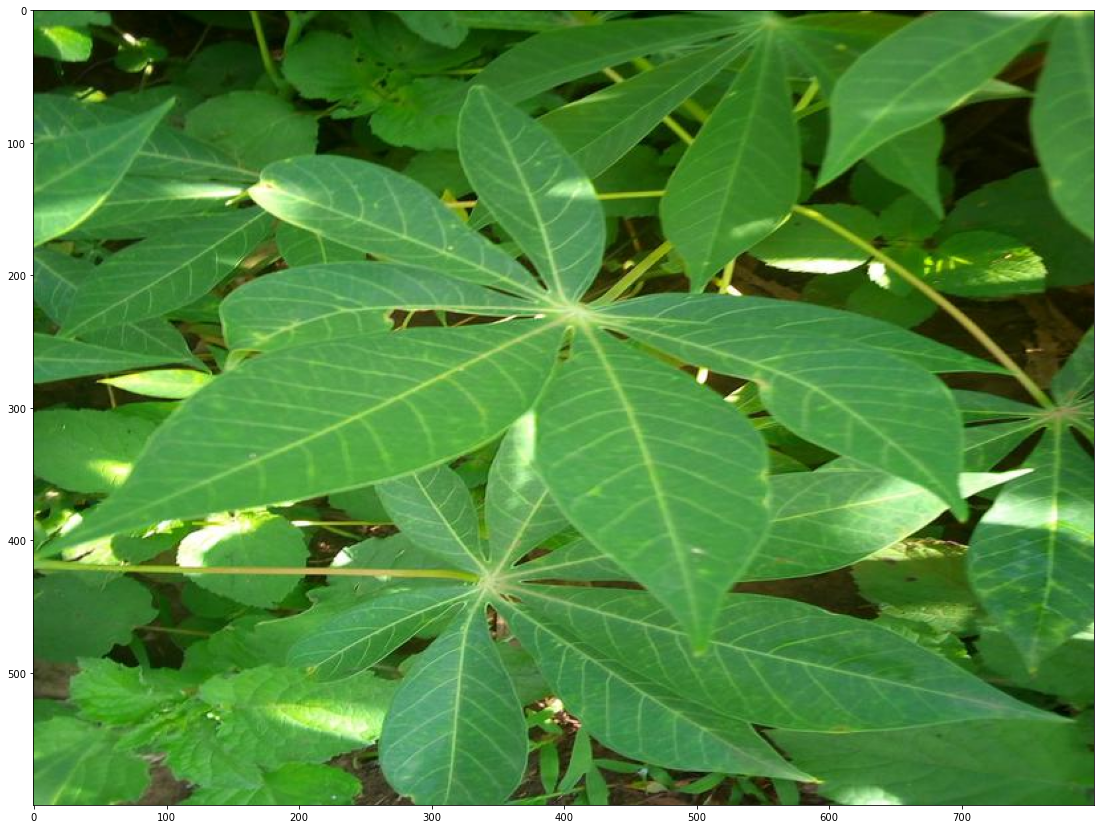

In [87]:
k = 2
img = get_img(os.path.join(TRAIN_IMAGES_DIR, folds.iloc[k, 0]))
plt.figure(figsize = (19, 25))
plt.imshow(img)

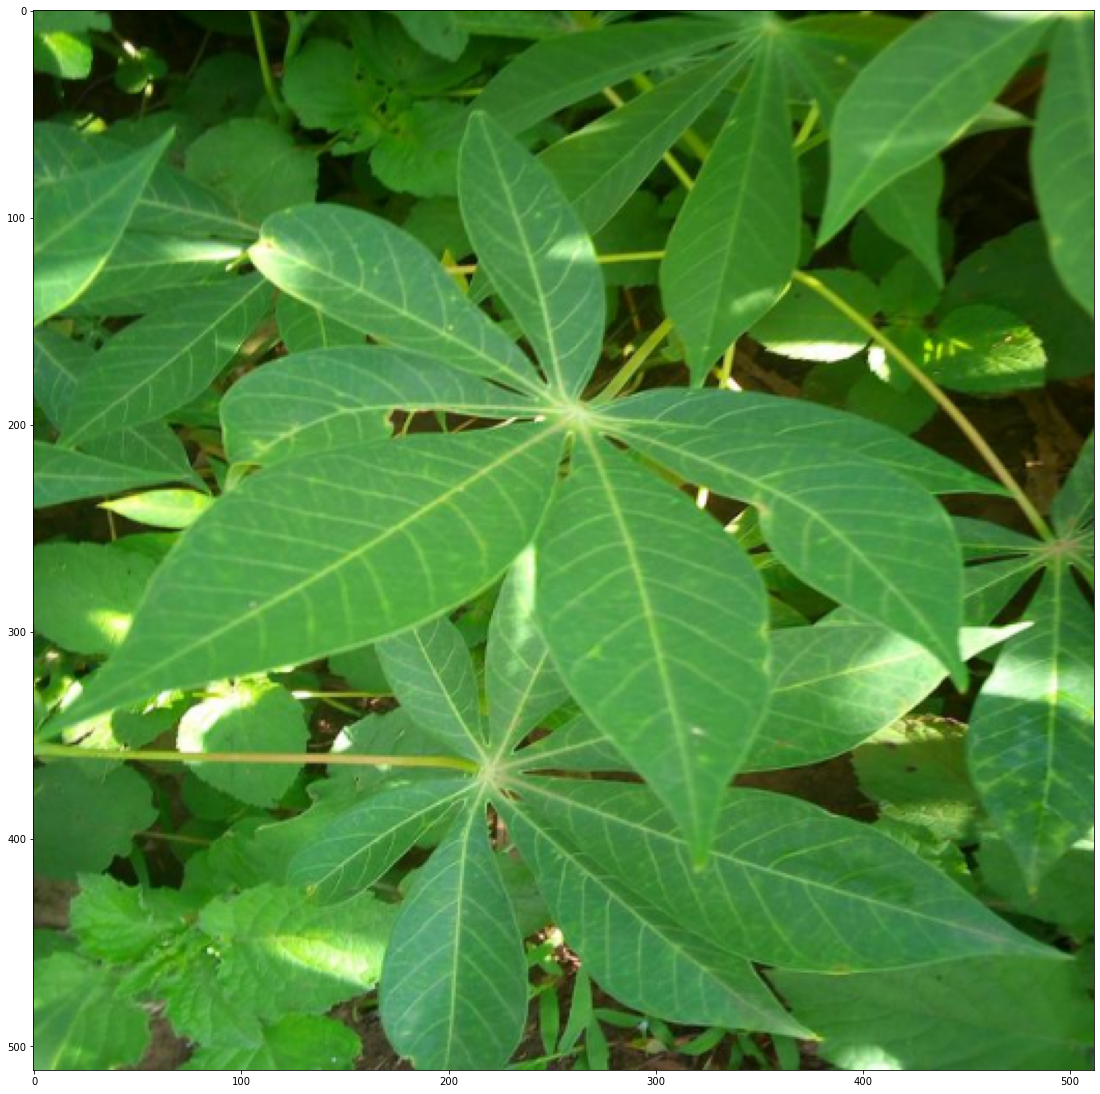

In [88]:
img = transform(image=img)['image']
plt.figure(figsize = (19, 25))
plt.imshow(img)

In [12]:
h = []
w = []

for i in tqdm(range(folds.shape[0])):
    dim = get_img(os.path.join(TRAIN_IMAGES_DIR, folds.iloc[i, 0])).shape
    h.append(dim[0])
    w.append(dim[1])

In [18]:
np.unique(w)

array([800])

In [22]:
a = [1, 5, 5, 2, 2, 6, 7, 7, 8, 8, 8, 2]
np.unique(a)

array([1, 2, 5, 6, 7, 8])

In [92]:
import timm
m = timm.create_model('seresnext50_32x4d', pretrained=True)
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEModule(
        (fc1): Conv2

In [94]:
import torch.nn as nn

model_ft = nn.Sequential(
    *list(timm.create_model('seresnext50_32x4d', pretrained=True).children())[
        :-2
        ]
)
model_ft

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEModule(
        (fc1): Conv2d(256, 16, kerne

In [42]:
import timm

model_arch = 'gluon_resnet18_v1b'
model = timm.create_model(model_arch, pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [100]:
import torch
inp = torch.randn((1, 3, 512, 512))
out = model_ft(inp)
out.size()

torch.Size([1, 2048, 16, 16])

In [103]:
from timm.models.layers.classifier import SelectAdaptivePool2d
out1 = SelectAdaptivePool2d(pool_type='avg', flatten=True)(out)
out1.size()

torch.Size([1, 2048])

In [104]:
out2 = nn.AdaptiveAvgPool2d((1, 1))(out)
out2.size()

torch.Size([1, 2048, 1, 1])

In [90]:
timm.list_models()

['adv_inception_v3',
 'cspdarknet53',
 'cspdarknet53_iabn',
 'cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'cspresnext50',
 'cspresnext50_iabn',
 'darknet53',
 'densenet121',
 'densenet121d',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenet264',
 'densenet264d_iabn',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn107',
 'dpn131',
 'eca_vovnet39b',
 'ecaresnet18',
 'ecaresnet50',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnetlight',
 'ecaresnext26tn_32x4d',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_b8',


In [66]:
m.classifier = torch.nn.Linear(1280, 5)
m

MobileNetV3(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): HardSwishMe()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
        (conv_pw): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(

AttributeError: 'MobileNetV3' object has no attribute 'bn'